In [1]:
import cv2
import numpy as np
import ect
import matplotlib.pyplot as plt

source_image_path = "../sample_imgs/shrek.png"

radius = 200
img_offset = radius/20
ect_offset = radius/50

config = ect.ECT_OFFSET_ORIGIN | ect.ECT_START_NY

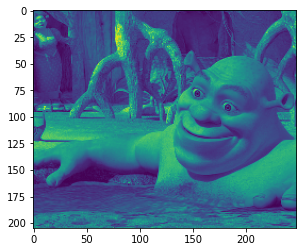

In [2]:
source_image = cv2.imread(source_image_path)
source_image = cv2.cvtColor(source_image, cv2.COLOR_RGB2GRAY)

# source_image = 255*np.ones_like(source_image, dtype=np.uint8)

f = plt.imshow(source_image)

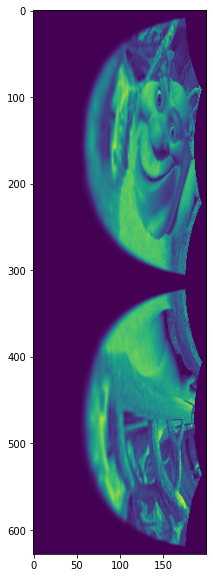

In [3]:
log_image = ect.logpolar(source_image, offset=img_offset, radius=radius, flags=config)

filt = ect.sidelobe(log_image.shape[:2], offset=img_offset, flags=config)

log_image = np.uint8(log_image*filt)

P, R = log_image.shape[:2]

# log_image[P//2:, :] = 0

f = plt.figure(figsize=(5, 10))
plt.imshow(log_image)

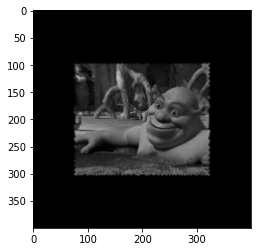

In [4]:
plt.imshow(ect.ilogpolar(log_image, offset=img_offset, flags=config))

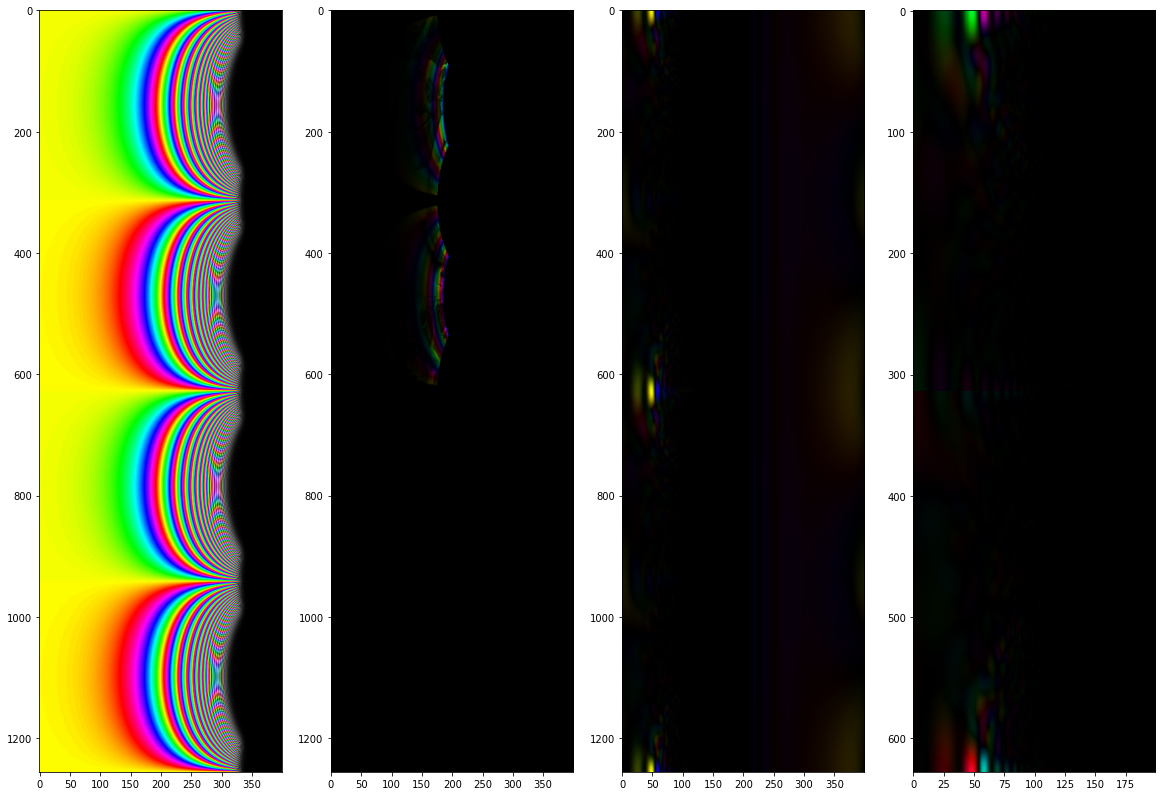

In [5]:
P, R = log_image.shape[:2]

rhos, phis, xs, ys = ect.kernel_vectors((P, R))
kernel = np.exp(-2*np.pi*1j*xs)

kernel = ect.antialias(
    kernel, 
    vectors = [xs, ys],
    factors = [.3, .2],
    thresholds = [np.log(R), 2*np.pi],
    slope = 0.5)

irhos, _, ixs, _ = ect.image_vectors((P, R), img_offset, config) #| ect.ECT_OFFSET_ORIGIN) 
krhos, _, kxs, _ = ect.image_vectors((P, R), ect_offset, config)
img_padded = np.zeros((2*P, 2*R, 1), dtype=complex)
img_padded[:P, :R] = np.conjugate(log_image) * np.exp(2*irhos - 2*np.pi*1j*ect_offset*ixs/R)

shift = np.exp(2*np.pi*1j*img_offset*kxs/R)

kernel_fft = np.fft.fft2(kernel, axes=(0, 1))
image_fft = np.fft.fft2(img_padded, axes=(0, 1))
xcorr = np.conjugate(image_fft) * kernel_fft
out = np.fft.ifft2(xcorr, axes=(0, 1))

# out = ect.xcorr(img_padded, kernel)
ect_out = out[:P, :R] * shift


plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
plt.imshow(ect.complex_to_hsv(kernel))

plt.subplot(1, 4, 2)
plt.imshow(ect.complex_to_hsv(img_padded))

plt.subplot(1, 4, 3)
plt.imshow(ect.complex_to_hsv(out))

plt.subplot(1, 4, 4)
plt.imshow(ect.complex_to_hsv(ect_out))

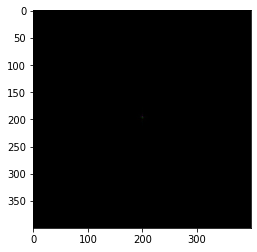

In [6]:
fft_image = ect.ilogpolar(ect.complex_to_hsv(ect_out), offset=0)

plt.imshow(fft_image)

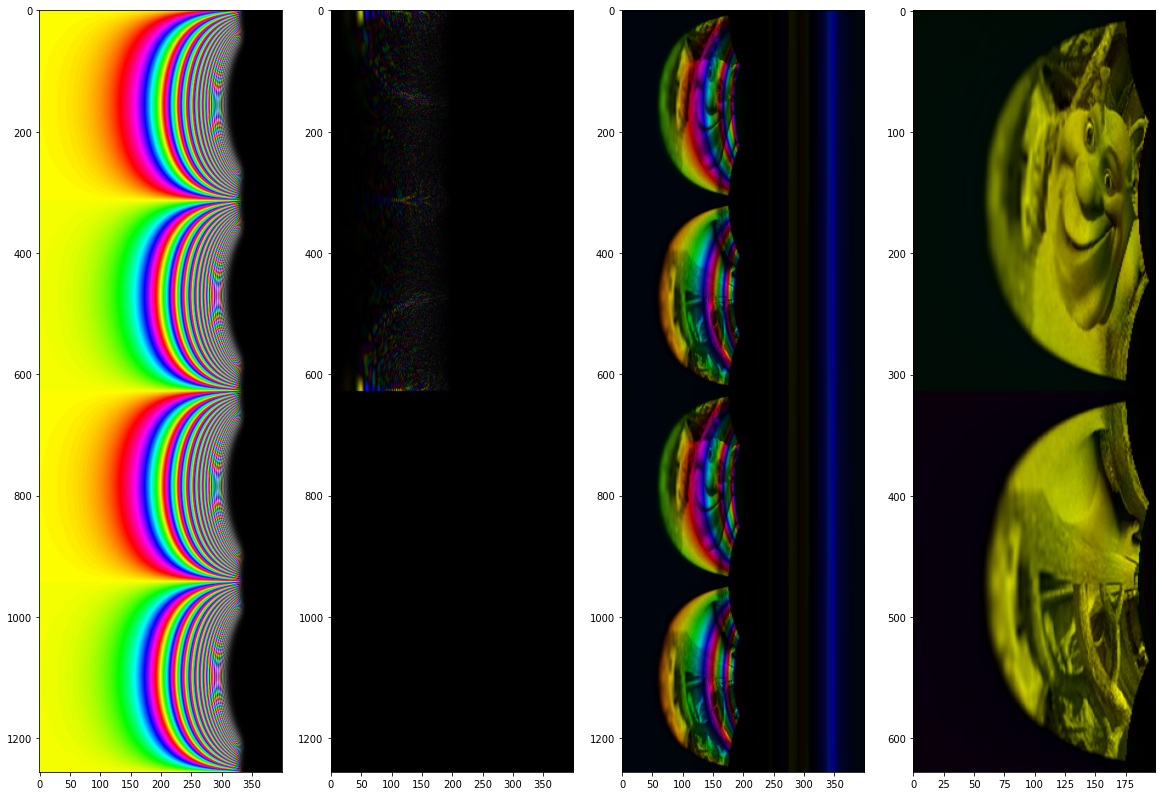

In [7]:
inv_kernel = np.exp(2*np.pi*1j*xs)

inv_kernel = ect.antialias(
    inv_kernel, 
    vectors = [xs, ys],
    factors = [.3, .2],
    thresholds = [np.log(R), 2*np.pi],
    slope = 0.5)


# ect_padded = ect.mod_image(ect_out, 0, flags=ect.ECT_OFFSET_ORIGIN)
# shift = ect.shift(ect_out, img_offset, 0)
krhos, _, kxs, _ = ect.image_vectors((P, R), ect_offset, config) 
irhos, _, ixs, _ = ect.image_vectors((P, R), img_offset, config)
ect_padded = np.zeros((2*P, 2*R, 1), dtype=complex)
ect_padded[:P, :R] = np.conjugate(ect_out) * np.exp(2*irhos + 2*np.pi*1j*img_offset*kxs/R)

shift = np.exp(-2*np.pi*1j*ect_offset*ixs/R)

inv_image = ect.xcorr(ect_padded, inv_kernel)
inv_out = inv_image[:P, :R]*shift
# inv_image = inv_image*filt


plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
plt.imshow(ect.complex_to_hsv(inv_kernel))

plt.subplot(1, 4, 2)
plt.imshow(ect.complex_to_hsv(ect_padded))

plt.subplot(1, 4, 3)
plt.imshow(ect.complex_to_hsv(inv_image))

plt.subplot(1, 4, 4)
plt.imshow(ect.complex_to_hsv(inv_out))

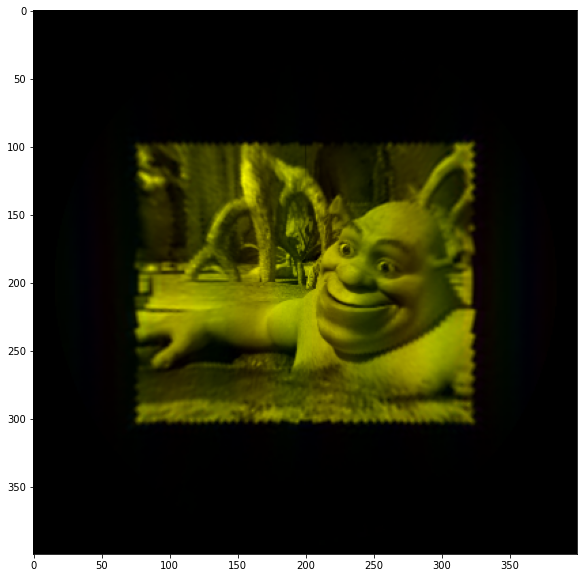

In [8]:
# result = ect.norm_minmax(np.abs(inv_out), 0, 100, dtype=np.float64)
result = ect.complex_to_hsv(inv_out)
inv = ect.ilogpolar(result, offset=img_offset)

# inv = ect.ilogpolar(
#     inv_out, 
#     offset=img_offset, 
#     flags=ect.ECT_START_NY | ect.ECT_INTER_NONE | ect.ECT_OFFSET_ORIGIN,
#     dtype=complex)

plt.figure(figsize=(10, 10))
plt.imshow(inv)